In [1]:
import pickle
from scipy.spatial import distance
from matplotlib.patches import Circle
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

my_map = [(0.0, 0.0), (0.0, 10.6), (6.6, 10.6), (6.6, 0.0)]
error_heatmap = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))
error_heatmap_performanceVSlocation = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))
average_maker = np.ones((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))
performance_location_maker = np.ones((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))
counter = 0

def AskLocationFromLocalizer(recent_grid):
    x, y = np.mean(zip(*np.where(recent_grid == np.max(recent_grid))), axis = 0)
    return [x/10, y/10]

# simworldname = ['simulationWorld(28jun1).xml', 'simulationWorld(28jun2).xml', 'simulationWorld(4jul11p).xml',
#                 'simulationWorld(4jul12p).xml', 'simulationWorld(4jul23p).xml', 'simulationWorld(4jul24p - unstable!).xml',
#                 'simulationWorld(5jul11p).xml', 'simulationWorld(5jul12p).xml', 'simulationWorld(6jul13p).xml',
#                 'simulationWorld(6jul14p).xml']

simworldname = ['simulationWorld(28jun1).xml', 'simulationWorld(28jun2).xml', 'simulationWorld(4jul11p).xml',
                'simulationWorld(4jul12p).xml', 'simulationWorld(4jul23p).xml',
                'simulationWorld(5jul11p).xml', 'simulationWorld(5jul12p).xml', 'simulationWorld(6jul13p).xml',
                'simulationWorld(6jul14p).xml']

# groundtruth = ['28jun1.csv', '28jun2.csv', '4jul11p.csv', '4jul12p.csv',
#                '4jul23p.csv', '4jul24p.csv', '5jul11p.csv', '5jul12p.csv',
#                '6jul13p.csv', '6jul14p.csv'

In [2]:
#####################################
##### ERROR HEATMAP CALCULATOR ######
#####################################

for dataselector in range(len(simworldname)):
    f = open('Data_' + simworldname[dataselector] + '.pckl', 'rb')
    data1, oracle1, analyzer1 = pickle.load(f)
    f.close()
    
    readable_time_oracle = []
    readable_time_analyzer = []
    estimated_location = []
    oracle_location = []

    for t in oracle1['time']:
        readable_time_oracle.append(int(datetime.utcfromtimestamp(t/1000).strftime('%H%M%S')))

    for t in analyzer1['time']:
        readable_time_analyzer.append(int(datetime.utcfromtimestamp(int(t)/1000).strftime('%H%M%S')))

    for g in analyzer1['gridmap']:
        estimated_location.append(AskLocationFromLocalizer(g))

    for t in oracle1['location']:
        oracle_location.append([t[0]/100, t[1]/100])

    for t in range(len(analyzer1['time'])):
        analyzer1['time'][t] = int(analyzer1['time'][t])
        
    deleted_times = []
    data2 = {}
    data2['time'] = []
    data2['location'] = []
    unpredicted_start = 0

    data2['time'] = sorted(set(analyzer1['time'] + oracle1['time']))

    for t in data2['time']:
        try:
            data2['location'].append(AskLocationFromLocalizer(analyzer1['gridmap'][analyzer1['time'].index(t)]))
        except:
            try:
                # print(len(data2['location']) - 1)
                # print(data2['location'][len(data2['location']) - 1])
                data2['location'].append(data2['location'][len(data2['location']) - 1])
                # print(len(data2['location']))
            except:
                #print("wtg")
                deleted_times.append(t)
                unpredicted_start = unpredicted_start + 1
                data2['location'].append([0,0])

    
    # for t in deleted_times:
    #    data2['time'].remove(t)

    temp_time = []
    for t in data2['time']:
        temp_time.append(int(datetime.utcfromtimestamp(int(t)/1000).strftime('%H%M%S')))
    
    for t in oracle1['time']:
        counter = counter + 1
        r = 60
        x = oracle1['location'][oracle1['time'].index(t)][0]
        y = oracle1['location'][oracle1['time'].index(t)][1]
        
        # print((x, y))
        
        circ = Circle((int(int(x)/10), int(int(y)/10)), int(int(r)/10))

        for i in range(len(error_heatmap[:,1])):
            for j in range(len(error_heatmap[1,:])):        
                if (circ.contains_point([i, j])):
                    x_hat = data2['location'][data2['time'].index(t)][0] * 100
                    y_hat = data2['location'][data2['time'].index(t)][1] * 100
                    # print((x_hat, y_hat))
                    # print("------------------------")
                    error_heatmap[i][j] += (distance.euclidean([x, y], [x_hat, y_hat]))
                    average_maker[i][j] += 1



In [69]:
performance_location_maker = pow(average_maker, 1/counter)
mask1 = (error_heatmap == average_maker) & (error_heatmap == 0)
mask2 = (error_heatmap == performance_location_maker) & (error_heatmap == 0)
error_heatmap_averaged = np.where(mask1, 0, np.true_divide(error_heatmap, average_maker))
error_heatmap_performanceVSlocation = np.where(mask2, 0, np.true_divide(error_heatmap, performance_location_maker))

xmax, xmin = error_heatmap_averaged.max(), error_heatmap_averaged.min()
error_heatmap_averaged = (error_heatmap_averaged - xmin)/(xmax - xmin)

xmax, xmin = error_heatmap_performanceVSlocation.max(), error_heatmap_performanceVSlocation.min()
error_heatmap_performanceVSlocation = (error_heatmap_performanceVSlocation - xmin)/(xmax - xmin)

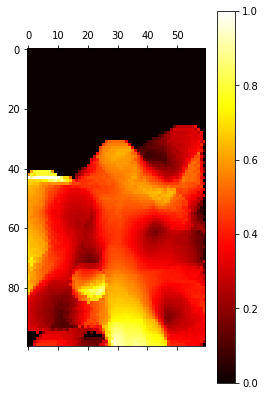

In [70]:
#######################################################
##### ERROR HEATMAP BASED ON OVERALL PERFORMANCE ######
#######################################################
import pylab as pl
from matplotlib.colors import LogNorm

im = plt.matshow(zip(*error_heatmap_averaged), cmap=pl.cm.hot) # pl is pylab imported a pl
plt.colorbar(im)
plt.show()

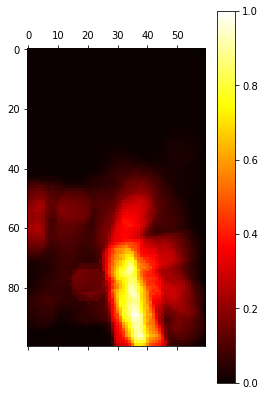

In [71]:
##########################################################
##### ERROR HEATMAP BASED ON IMPORTANCE OF LOCATION ######
##########################################################
import pylab as pl
from matplotlib.colors import LogNorm

im = plt.matshow(zip(*error_heatmap_performanceVSlocation), cmap=pl.cm.hot) # pl is pylab imported a pl
plt.colorbar(im)
plt.show()


In [ ]:
####################################
##### GRANULARITY LEVEL: ROOM ######
####################################

my_map = [(0.0, 0.0), (0.0, 10.6), (6.6, 10.6), (6.6, 0.0)]
error_heatmap = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))
average_maker = np.ones((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))

bedroom_area = [(0.0, 0.0), (2.9, 4.6)]
living_area = [(3.0, 0.0), (6.6, 4.7)]
dining_area = [(1.7, 4.7), (6.6, 7.7)]
kitchen_area = [(1.7, 7.8), (6.6, 10.6)]
bathroom_area = [(0.0, 4.7), (1.5, 7.6)]

CMatrix = np.zeros((5, 5))

for dataselector in range(len(simworldname)):
    f = open('Data_' + simworldname[dataselector] + '.pckl', 'rb')
    data1, oracle1, analyzer1 = pickle.load(f)
    f.close()
    
    readable_time_oracle = []
    readable_time_analyzer = []
    estimated_location = []
    oracle_location = []

    for t in oracle1['time']:
        readable_time_oracle.append(int(datetime.utcfromtimestamp(t/1000).strftime('%H%M%S')))

    for t in analyzer1['time']:
        readable_time_analyzer.append(int(datetime.utcfromtimestamp(int(t)/1000).strftime('%H%M%S')))

    for g in analyzer1['gridmap']:
        estimated_location.append(AskLocationFromLocalizer(g))

    for t in oracle1['location']:
        oracle_location.append([t[0]/100, t[1]/100])

    for t in range(len(analyzer1['time'])):
        analyzer1['time'][t] = int(analyzer1['time'][t])
        
    deleted_times = []
    data2 = {}
    data2['time'] = []
    data2['location'] = []
    unpredicted_start = 0

    data2['time'] = sorted(set(analyzer1['time'] + oracle1['time']))

    for t in data2['time']:
        try:
            data2['location'].append(AskLocationFromLocalizer(analyzer1['gridmap'][analyzer1['time'].index(t)]))
        except:
            try:
                # print(len(data2['location']) - 1)
                # print(data2['location'][len(data2['location']) - 1])
                data2['location'].append(data2['location'][len(data2['location']) - 1])
                # print(len(data2['location']))
            except:
                #print("wtg")
                deleted_times.append(t)
                unpredicted_start = unpredicted_start + 1
                data2['location'].append([0,0])

    
    # for t in deleted_times:
    #    data2['time'].remove(t)

    temp_time = []
    for t in data2['time']:
        temp_time.append(int(datetime.utcfromtimestamp(int(t)/1000).strftime('%H%M%S')))
    
    for t in oracle1['time']:
        x = oracle1['location'][oracle1['time'].index(t)][0] /100
        y = oracle1['location'][oracle1['time'].index(t)][1] /100
        
        x_hat = data2['location'][data2['time'].index(t)][0]
        y_hat = data2['location'][data2['time'].index(t)][1]
        
        # print((x, y))
        # print((x_hat, y_hat))
        # print("-------------")
        
        if (x >= bedroom_area[0][0] and x <= bedroom_area[1][0] and y >= bedroom_area[0][1] and y <= bedroom_area[1][1]):    
            if (x_hat >= bedroom_area[0][0] and x_hat <= bedroom_area[1][0] and y_hat >= bedroom_area[0][1] and y_hat <= bedroom_area[1][1]):
                CMatrix[0,0] = CMatrix[0,0] + 1
            if (x_hat >= living_area[0][0] and x_hat <= living_area[1][0] and y_hat >= living_area[0][1] and y_hat <= living_area[1][1]):
                CMatrix[1,0] = CMatrix[1,0] + 1
            if (x_hat >= dining_area[0][0] and x_hat <= dining_area[1][0] and y_hat >= dining_area[0][1] and y_hat <= dining_area[1][1]):
                CMatrix[2,0] = CMatrix[2,0] + 1
            if (x_hat >= kitchen_area[0][0] and x_hat <= kitchen_area[1][0] and y_hat >= kitchen_area[0][1] and y_hat <= kitchen_area[1][1]):
                CMatrix[3,0] = CMatrix[3,0] + 1
            if (x_hat >= bathroom_area[0][0] and x_hat <= bathroom_area[1][0] and y_hat >= bathroom_area[0][1] and y_hat <= bathroom_area[1][1]):
                CMatrix[4,0] = CMatrix[4,0] + 1

        if (x >= living_area[0][0] and x <= living_area[1][0] and y >= living_area[0][1] and y <= living_area[1][1]):     
            if (x_hat >= bedroom_area[0][0] and x_hat <= bedroom_area[1][0] and y_hat >= bedroom_area[0][1] and y_hat <= bedroom_area[1][1]):
                CMatrix[0,1] = CMatrix[0,1] + 1
            if (x_hat >= living_area[0][0] and x_hat <= living_area[1][0] and y_hat >= living_area[0][1] and y_hat <= living_area[1][1]):
                CMatrix[1,1] = CMatrix[1,1] + 1
            if (x_hat >= dining_area[0][0] and x_hat <= dining_area[1][0] and y_hat >= dining_area[0][1] and y_hat <= dining_area[1][1]):
                CMatrix[2,1] = CMatrix[2,1] + 1
            if (x_hat >= kitchen_area[0][0] and x_hat <= kitchen_area[1][0] and y_hat >= kitchen_area[0][1] and y_hat <= kitchen_area[1][1]):
                CMatrix[3,1] = CMatrix[3,1] + 1
            if (x_hat >= bathroom_area[0][0] and x_hat <= bathroom_area[1][0] and y_hat >= bathroom_area[0][1] and y_hat <= bathroom_area[1][1]):
                CMatrix[4,1] = CMatrix[4,1] + 1
        
        if (x >= dining_area[0][0] and x <= dining_area[1][0] and y >= dining_area[0][1] and y <= dining_area[1][1]):    
            if (x_hat >= bedroom_area[0][0] and x_hat <= bedroom_area[1][0] and y_hat >= bedroom_area[0][1] and y_hat <= bedroom_area[1][1]):
                CMatrix[0,2] = CMatrix[0,2] + 1
            if (x_hat >= living_area[0][0] and x_hat <= living_area[1][0] and y_hat >= living_area[0][1] and y_hat <= living_area[1][1]):
                CMatrix[1,2] = CMatrix[1,2] + 1
            if (x_hat >= dining_area[0][0] and x_hat <= dining_area[1][0] and y_hat >= dining_area[0][1] and y_hat <= dining_area[1][1]):
                CMatrix[2,2] = CMatrix[2,2] + 1
            if (x_hat >= kitchen_area[0][0] and x_hat <= kitchen_area[1][0] and y_hat >= kitchen_area[0][1] and y_hat <= kitchen_area[1][1]):
                CMatrix[3,2] = CMatrix[3,2] + 1
            if (x_hat >= bathroom_area[0][0] and x_hat <= bathroom_area[1][0] and y_hat >= bathroom_area[0][1] and y_hat <= bathroom_area[1][1]):
                CMatrix[4,2] = CMatrix[4,2] + 1
        
        if (x >= kitchen_area[0][0] and x <= kitchen_area[1][0] and y >= kitchen_area[0][1] and y <= kitchen_area[1][1]):    
            if (x_hat >= bedroom_area[0][0] and x_hat <= bedroom_area[1][0] and y_hat >= bedroom_area[0][1] and y_hat <= bedroom_area[1][1]):
                CMatrix[0,3] = CMatrix[0,3] + 1
            if (x_hat >= living_area[0][0] and x_hat <= living_area[1][0] and y_hat >= living_area[0][1] and y_hat <= living_area[1][1]):
                CMatrix[1,3] = CMatrix[1,3] + 1
            if (x_hat >= dining_area[0][0] and x_hat <= dining_area[1][0] and y_hat >= dining_area[0][1] and y_hat <= dining_area[1][1]):
                CMatrix[2,3] = CMatrix[2,3] + 1
            if (x_hat >= kitchen_area[0][0] and x_hat <= kitchen_area[1][0] and y_hat >= kitchen_area[0][1] and y_hat <= kitchen_area[1][1]):
                CMatrix[3,3] = CMatrix[3,3] + 1
            if (x_hat >= bathroom_area[0][0] and x_hat <= bathroom_area[1][0] and y_hat >= bathroom_area[0][1] and y_hat <= bathroom_area[1][1]):
                CMatrix[4,3] = CMatrix[4,3] + 1
                
        if (x >= bathroom_area[0][0] and x <= bathroom_area[1][0] and y >= bathroom_area[0][1] and y <= bathroom_area[1][1]):    
            if (x_hat >= bedroom_area[0][0] and x_hat <= bedroom_area[1][0] and y_hat >= bedroom_area[0][1] and y_hat <= bedroom_area[1][1]):
                CMatrix[0,4] = CMatrix[0,4] + 1
            if (x_hat >= living_area[0][0] and x_hat <= living_area[1][0] and y_hat >= living_area[0][1] and y_hat <= living_area[1][1]):
                CMatrix[1,4] = CMatrix[1,4] + 1
            if (x_hat >= dining_area[0][0] and x_hat <= dining_area[1][0] and y_hat >= dining_area[0][1] and y_hat <= dining_area[1][1]):
                CMatrix[2,4] = CMatrix[2,4] + 1
            if (x_hat >= kitchen_area[0][0] and x_hat <= kitchen_area[1][0] and y_hat >= kitchen_area[0][1] and y_hat <= kitchen_area[1][1]):
                CMatrix[3,4] = CMatrix[3,4] + 1
            if (x_hat >= bathroom_area[0][0] and x_hat <= bathroom_area[1][0] and y_hat >= bathroom_area[0][1] and y_hat <= bathroom_area[1][1]):
                CMatrix[4,4] = CMatrix[4,4] + 1

print("finished")

In [ ]:
print("Bedroom, Livingroom, Dinignroom, Kitchen, Bathroom")
print(CMatrix)

In [ ]:
bedroom_acc = CMatrix[0,0] / np.sum(CMatrix[:,0])
living_acc = CMatrix[1,1] / np.sum(CMatrix[:,1])
dining_acc = CMatrix[2,2] / np.sum(CMatrix[:,2])
kitchen_acc = CMatrix[3,3] / np.sum(CMatrix[:,3])
bathroom_acc = CMatrix[4,4] / np.sum(CMatrix[:,4])

acc = (bedroom_acc + living_acc + kitchen_acc + bathroom_acc + bathroom_acc) / 5
print(acc)

In [ ]:
print(bedroom_acc)
print(living_acc)
print(kitchen_acc)
print(bathroom_acc)
print(dining_acc)